# Gain variation with time

How the gains vary with time directly affects how frequently you have to calibrate the antennas. 

If you calibrate only a subset of baselines you need to calibrate for longer to acheive the same SNR. But if the gain variations on short scales are high, the integration will wash out the structure.

<IPython.core.display.Javascript object>


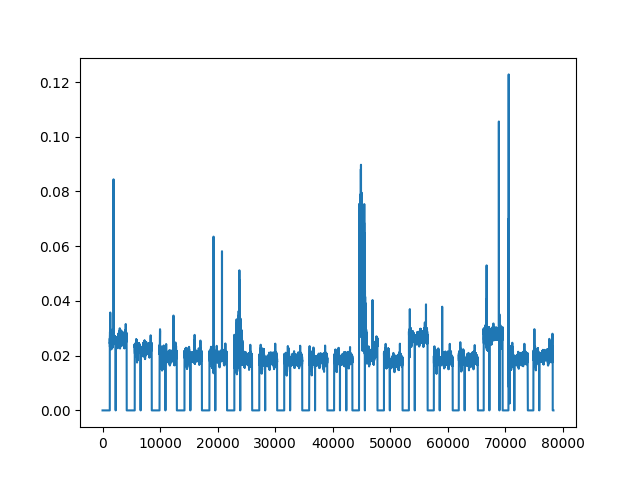

In [5]:
files = glob.glob('hera_idr2p1_gains/245*')
files.sort()

# Forgot to load this into file header
INT_TIME = 10.73741912841797

g = []; flags = []

for fn in files:
    with open(fn,'r') as fp:
        data = cp.load(fp)
    g.append(data['gains'])
    flags.append(data['flags'])
    
# Flags are 0 where there is data and 
# 1 where there is **no** data
flags = np.concatenate(np.concatenate(flags))
wgts = np.logical_not(flags)
g = np.concatenate(np.concatenate(g))

g = g * wgts

plt.figure()
plt.plot(np.abs(g))

# Single day gain variation

The above plot shows that the most of the variation is in small fringe-rates (long time periods) which is awesome because I can integrate on short scales without loss of information. Analysing a single day gain variation to confirm this.

In [ ]:
with open(files[1],'r') as fp:
    data = cp.load(fp)

In [ ]:
# Determine number of measurements = total number of baselines (including redundant)
with open('hera_idr2p1_gains/antpos_52ants.cp','r') as fp:
    antpos_52 = cp.load(fp)

redbls_52 = hera_cal.redcal.get_pos_reds(antpos_52)
allbls = [bl for red in redbls_52 for bl in red]

plt.figure()
plot_ants(antpos_52)

<IPython.core.display.Javascript object>


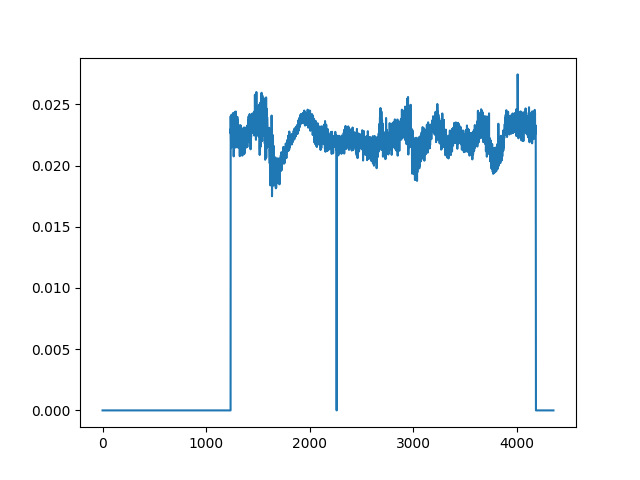

In [12]:
dflags = np.concatenate(data['flags'])
dgains = np.concatenate(data['gains'])

dwgts = np.logical_not(dflags)
dgains = dgains*dwgts

time_range = np.arange(np.size(dgains))*INT_TIME

plt.figure()
plt.plot(np.abs(dgains))

<IPython.core.display.Javascript object>


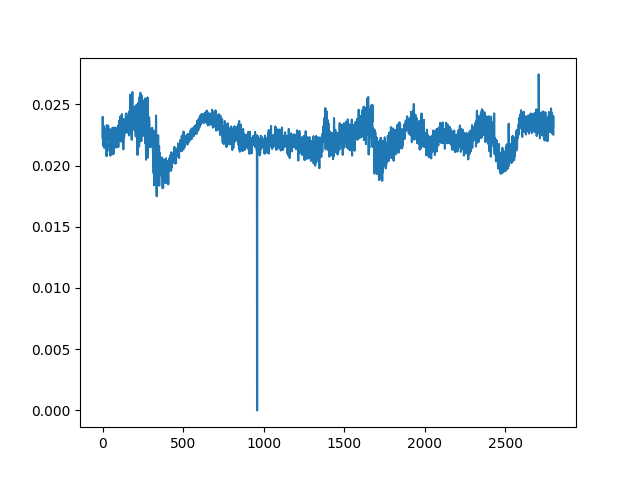

In [13]:
# Cut out flagged areas
dgains = dgains[1300:4100]
dwgts = dwgts[1300:4100]
time_range = time_range[1300:4100]

plt.figure()
plt.plot(np.abs(dgains))

In [14]:
# Deconvolve to interpolate the single flagged value

Fdg = np.fft.ifft(dgains)
Fdker = np.fft.ifft(dwgts)

fringe_rate = np.fft.fftfreq(np.size(time_range),d=INT_TIME)

Fdg_deconv = aipy.deconv.clean(im = Fdg, ker = Fdker, tol=1e-6)

In [15]:
Fdg_deconv[1]

{'iter': 10000,
 'res': array([ 1.15126642e-05-4.78090164e-06j,  9.53710223e-06-8.57199339e-06j,
         2.30114296e-06+1.33140272e-05j, ...,
         1.15237720e-05+4.23843489e-06j,  7.34129724e-06+9.93598950e-06j,
        -1.11763260e-05-6.53824098e-06j]),
 'score': 1.1682065205404882e-05,
 'success': False,
 'term': 'maxiter',
 'tol': 1e-06}

In [ ]:
# Interpolated and cleaned gains for a single day
gains_day = np.abs(np.fft.fft(Fdg_deconv[0] + Fdg_deconv[1]['res']))

# Check that the fourier transform converged
plt.figure()
plt.plot(time_range/(60*60),gains_day)
plt.plot(time_range/(60*60),np.abs(dgains),'--r',alpha=0.5)
plt.xlabel('Time [in hours]')

To understand how frequently you need to calibrate the gains:

1. Sample the gains at different time periods- different sampling frequencies will result in different 

In [ ]:
gain_varfft = {}
for i in range(1,100,1):
    g = gains_day[::i]
    gain_varfft[(i,'freq')] = np.fft.fftfreq(len(g),d=i*INT_TIME)
    gain_varfft[(i,'ifft')] = np.fft.ifft(g)

In [ ]:
plt.figure()
plt.semilogy(gain_varfft[(1,'freq')],np.abs(gain_varfft[(1,'ifft')])**2)

In [ ]:
plt.figure()
for i in range(10,100,10):
    plt.plot(gain_varfft[(i,'freq')],np.abs(gain_varfft[(i,'ifft')]),'.',label=i,alpha=0.7)
plt.legend()

In [ ]:
gain_varfft[(1,'freq')]

In [ ]:
plt.figure()

Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 100e6/1024
Nmeas = len(allbls)
#noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas))

for i in range(1,100,1):
    num = len(gain_varfft[(i,'ifft')])
    plt.semilogx(num, np.abs(gain_varfft[(i,'ifft')][3])**2,'ok',label=i)
    noise = Tsys/(np.sqrt(1326*INT_TIME*B*num))
    plt.semilogx(num, noise**2,'.r')
    #print i,num
    #plt.semilogx(num, 0.3e-2*np.sqrt(1.0/num),'.r')
    

In [ ]:
Favg = np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res'])**2
Favg = np.mean(Favg.reshape(-1,5),axis=1)
np.shape(Favg)

In [ ]:
Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 100e6/1024
Nmeas = len(allbls)  # From the corresponding UVData (uvOCR) file = 1326

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(np.fft.fftshift(Favg))
plt.semilogy(np.repeat(noise**2,len(Favg)))

In [ ]:
noise = Tsys/(np.sqrt(52*INT_TIME*B*350))
noise

In [ ]:
len(allbls)

In [ ]:
plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.legend()

In [ ]:
Tsys = 500.
Tsrc = 5.
B = 250e6/4096

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(Nbls*(4100-1300)*INT_TIME*B)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.semilogy(fringe_rate,np.repeat(noise,len(fringe_rate)))
#plt.plot(fringe_rate, np.abs(np.fft.fft(noise)))

# Integration time

In [ ]:
Tsys = 500
Tsrc = 5
B = 250e6/4096

Sr_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Sr])
Si_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Si])

tr = Tsys**2/(B*Tsrc**2)*Sr_inv
ti = Tsys**2/(B*Tsrc**2)*Si_inv

plt.plot(tr,'o-',label='Real')
plt.plot(ti,'o-',label='Imag')
plt.legend()
plt.show()